# Well Log Correlation Using Modified Dynamic Time Warping

---

---
## Contents
1. [Introduction](#Introduction)
2. [Data Preparation](#Data-Preparation)
3. [Choosing the Reference Well](#Choosing-the-Reference-Well)
4. [Doing Final Multi-Well Correlation](#Doing-Final-Multi-Well-Correlation)
5. [Generating and saving the results / report](#Generating-and-saving-the-results-/-report)

---
## Introduction

Well log correlation is a tedious task and might require additional data such as seismic or core measurements. Dynamic Time Warping (DTW) is a popular method for automating this process (for more details about DTW, see https://en.wikipedia.org/wiki/Dynamic_time_warping ). However, DTW suffers from problems such as non-uniqueness where we have one data point on time series A mapped to several data points on time series B. In order to address these shortcomings of DTW, we propose a hybrid/ modified version of DTW which tries to keep the best path between two points on time series. This involves removing of some paths which is done using a filter that identifies similar data points that are too close to each other.

This is a completely automated workflow meaning that it does not need any form initial interpretation etc. The only thinkg required from user is the name of a reference well and a resolution parameter which controls the number of layers we will get. In this workflow, we start with a reference well, pick the layer boundaries (automatically) on the  reference well, and then try to find the matching points on every other well. If the user wants to provide manually picked boundaries for the reference well, that can be implemented with very minor changes in the code as well. 

The method used for picking layer boundaries used in this notebook is based on the change in convexity of the time series (well logs). Well logs are smoothed automatically based on the resolution parameter, and then we search for the zero-crossings (inflection points) on the smoothed log curves. These zero-crossings are assumed to be the layer boundaries. Resolution parameter can be any positive number between. However, for well log applications, values should be chosen in the range of ~ 5-30. The higher value for resolution parameter means less number of picked layers and vice versa.

Here we will provide the list of required libraries and also functions required to run this application:

In [ ]:

import time
notebookstart= time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
print("Data:\n",os.listdir("../input"))

# Models Packages
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Viz
import seaborn as sns
import matplotlib.pyplot as plt

print("\nData Load Stage")
training = pd.read_csv('../input/train.csv', index_col = "item_id", parse_dates = ["activation_date"])#.sample(1000)
traindex = training.index
testing = pd.read_csv('../input/test.csv', index_col = "item_id", parse_dates = ["activation_date"])#.sample(1000)
testdex = testing.index
y = training.deal_probability.copy()
training.drop("deal_probability",axis=1, inplace=True)
print('Train shape: {} Rows, {} Columns'.format(*training.shape))
print('Test shape: {} Rows, {} Columns'.format(*testing.shape))

# Combine Train and Test
df = pd.concat([training,testing],axis=0)
del training, testing
gc.collect()
print('\nAll Data shape: {} Rows, {} Columns'.format(*df.shape))

print("Feature Engineering")
df["price"] = np.log(df["price"]+0.001)
df["price"].fillna(-999,inplace=True)
df["image_top_1"].fillna(-999,inplace=True)

print("\nCreate Time Variables")
df["Weekday"] = df['activation_date'].dt.weekday
df["Weekd of Year"] = df['activation_date'].dt.week
df["Day of Month"] = df['activation_date'].dt.day

# Remove Dead Variables
df.drop(["activation_date","image"],axis=1,inplace=True)

print("\nEncode Variables")
categorical = ["user_id","region","city","parent_category_name","category_name","item_seq_number","user_type","image_top_1"]
messy_categorical = ["param_1","param_2","param_3","title","description"] # Need to find better technique for these
print("Encoding :",categorical + messy_categorical)

# Encoder:
lbl = preprocessing.LabelEncoder()
for col in categorical + messy_categorical:
    df[col] = lbl.fit_transform(df[col].astype(str))
    
print("\nCatboost Modeling Stage")
X = df.loc[traindex,:].copy()
print("Training Set shape",X.shape)
test = df.loc[testdex,:].copy()
print("Submission Set Shape: {} Rows, {} Columns".format(*test.shape))
del df
gc.collect()

# Training and Validation Set
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.10, random_state=23)

# Prepare Categorical Variables
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]
categorical_features_pos = column_index(X,categorical + messy_categorical)

# Train Model
print("Train CatBoost Decision Tree")
modelstart= time.time()
cb_model = CatBoostRegressor(iterations=700,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='RMSE',
                             random_seed = 23,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100)
cb_model.fit(X_train, y_train,
             eval_set=(X_valid,y_valid),
             cat_features=categorical_features_pos,
             use_best_model=True,
             verbose=True)

# # Feature Importance
# fea_imp = pd.DataFrame({'imp': cb_model.feature_importances_, 'col': X.columns})
# fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
# _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
# plt.savefig('catboost_feature_importance.png')   

print("Model Evaluation Stage")
print(cb_model.get_params())
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, cb_model.predict(X_valid))))
catpred = cb_model.predict(test)
catsub = pd.DataFrame(catpred,columns=["deal_probability"],index=testdex)
catsub['deal_probability'].clip(0.0, 1.0, inplace=True)
catsub.to_csv("catsub.csv",index=True,header=True) # Between 0 and 1
print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))
show less
Did you find this Kernel useful?
Show your appreciation with an upvote







In [150]:
!pip install catboost

    100% |████████████████████████████████| 6.4MB 254kB/s ta 0:00:01
You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [151]:
import DTW_Corr as dc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import lasio
import math
import random
from scipy import interpolate
from matplotlib.pyplot import cm
from matplotlib import style
from sklearn import preprocessing
from catboost import CatBoostRegressor

style.use('ggplot')
%matplotlib inline

In [20]:
def data_cut(datasub, survey, wells):
    cols = datasub.columns.tolist()
    data_reg = pd.DataFrame()
    for w in wells:
        data_1well = datasub[datasub['WELL_NAME']==w]
        subsurvey = survey[survey['Well ID']==w]
        data_1well  = data_1well[data_1well['DEPT'] >= subsurvey['MD'].values[0]]
        data_1well  = data_1well[data_1well['DEPT'] <= subsurvey['MD'].values[1]] 
        data_reg = data_reg.append(data_1well)
    return data_reg 

In [111]:
def scatter_plot(yts,yhat,method):
    plt.plot(yts,yhat,'o')#,[1:len(yhat)])
    t = 'Predicted Failure Status ( from '+method+' method)'
    plt.title(t)
    plt.xlabel('Device actual remaining life in days')
    plt.ylabel('Device predicted remaining life in days')
    plt.savefig(method+'_scatter.png')
    plt.show()

In [72]:
"""
This function takes a survey data frame which has X and Y and well name info, and sorts wells based on their distance
from a given reference well. It retuns a sorted data frame based on these distances

Inputs:
    survey: survey data frame containing tops and bottoms of intervals of interest
    wells  : list of all well names 
    w1: name of reference well
    
Outputs:
    wells_sorted: survey data frame after being sorted based on distances
"""
def find_closest_wells(survey50, survey5, w1, wells50):
    subsurvey5 = survey5[survey5['Surface']=='GRAPIDS']
    x0 = subsurvey5[subsurvey5['Well ID'] == w1].X.values
    y0 = subsurvey5[subsurvey5['Well ID'] == w1].Y.values

    subsurvey50 = survey50[survey50['Surface']=='GRAPIDS']
    subsurvey50['Dist'] = 0.
    for i, txt in enumerate(wells50):
        dist = np.sqrt((x0 - subsurvey50[subsurvey50['Well ID'] == txt].X.values)**2 + (y0 - subsurvey50[subsurvey50['Well ID'] == txt].Y.values)**2)  
        subsurvey50['Dist'][subsurvey50['Well ID']== txt] = dist

    subsurvey50 = subsurvey50.sort_values(by='Dist')
    wells_sorted = subsurvey50['Well ID'].values.tolist()
    return wells_sorted

## Data Preparation

Here we will gather all LAS files from 50 wells into one single pandas data frame. We will also select data for each well only inside the interval of interest. These interval info was provided by ExxonMobil. Well logs came in 3 different depth increments. We process all of these wells to have the same depth increment: 0.1m.

Gather all LAS files in one data frame:

In [36]:
subsurvey = survey50[survey50['Well ID']==wells50[0]]
print(subsurvey)

data_1well = data50[data50['WELL_NAME']==wells50[0]]
# data_1well  = data_1well[data_1well['DEPT'] >= subsurvey['MD'].values[0]]
print(subsurvey['MD'].values[0])
data_1well.head()

a = data_1well['DEPT']
print(a.dtype)

a = subsurvey['MD'].values[0]
print(a.dtype)

print(data_1well['DEPT'])

                  Well ID  Surface          X           Y      MD
0  W4.065.03.35.06(1AA00)  GRAPIDS  542136.46  6057826.47  300.63
1  W4.065.03.35.06(1AA00)    MCMRY  542136.46  6057826.47  479.73
300.63
object
float64
0       142.875
1         143.0
2       143.125
3        143.25
4       143.375
5         143.5
6       143.625
7        143.75
8       143.875
9         144.0
10      144.125
11       144.25
12      144.375
13        144.5
14      144.625
15       144.75
16      144.875
17        145.0
18      145.125
19       145.25
20      145.375
21        145.5
22      145.625
23       145.75
24      145.875
25        146.0
26      146.125
27       146.25
28      146.375
29        146.5
         ...   
2890    504.125
2891     504.25
2892    504.375
2893      504.5
2894    504.625
2895     504.75
2896    504.875
2897      505.0
2898    505.125
2899     505.25
2900    505.375
2901      505.5
2902    505.625
2903     505.75
2904    505.875
2905      506.0
2906    506.125
2907     506

In [149]:
path = r'/Users/mehdf/Documents/My_files/Environments/petrophysics/Exxon/UC2/50 wells/Well Logs Basic'
data50 = dc.ReadAllLasFile(path, plot = False)#list wells to test
survey50 = pd.read_excel('/Users/mehdf/Documents/My_files/Environments/petrophysics/Exxon/UC2/50 wells/Interval_of_Interest_Tops_for_50_Initial_Wells.xlsx')
wells50 = survey50['Well ID'].unique()
# display(survey.head())
subsurvey50 = survey50[survey50['Surface']=='GRAPIDS']
xc50 = subsurvey50['X'].values
yc50 = subsurvey50['Y'].values

path = r'/Users/mehdf/Documents/My_files/Environments/petrophysics/Exxon/UC2/12 blind test wells/Wells logs basic'
data12 = dc.ReadAllLasFile(path, plot = False)#list wells to test
survey12 = pd.read_excel('/Users/mehdf/Documents/My_files/Environments/petrophysics/Exxon/UC2/12 blind test wells/Interval_of_Interest_Tops_for_12_Blind_Test_Wells.xlsx')
wells12 = survey12['Well ID'].unique()
subsurvey12 = survey12[survey12['Surface']=='GRAPIDS']
xc12 = subsurvey12['X'].values
yc12 = subsurvey12['Y'].values


path = r'/Users/mehdf/Documents/My_files/Environments/petrophysics/Exxon/UC2/5 supplimentary test wells/Well logs'
data5 = dc.ReadAllLasFile(path, plot = False)#list wells to test
survey5 = pd.read_excel('/Users/mehdf/Documents/My_files/Environments/petrophysics/Exxon/UC2/5 supplimentary test wells/Interval_of_Interest_Tops_for_5_Supp_Wells.xlsx')
wells5 = survey5['Well ID'].unique()
subsurvey5 = survey5[survey5['Surface']=='GRAPIDS']
xc5 = subsurvey5['X'].values
yc5 = subsurvey5['Y'].values


0
/Users/mehdf/Documents/My_files/Environments/petrophysics/Exxon/UC2/50 wells/Well Logs Basic/W4_065_03_35_06(1AA00).las
['DEPT', 'CALI', 'GR', 'PEF', 'SP', 'DRES', 'NPSS', 'RHOB', 'DT', 'WELL_NAME']
W4.065.03.35.06(1AA00)
1
/Users/mehdf/Documents/My_files/Environments/petrophysics/Exxon/UC2/50 wells/Well Logs Basic/W4_065_03_36_05(1AA00).las
['DEPT', 'CALI', 'DRES', 'NPSS', 'RHOB', 'DT', 'GR', 'PEF', 'SP', 'WELL_NAME']
W4.065.03.36.05(1AA00)
2
/Users/mehdf/Documents/My_files/Environments/petrophysics/Exxon/UC2/50 wells/Well Logs Basic/W4_065_03_36_13(1AA00).las
['DEPT', 'CALI', 'DRES', 'NPSS', 'RHOB', 'GR', 'PEF', 'SP', 'DT', 'WELL_NAME']
W4.065.03.36.13(1AA00)
3
/Users/mehdf/Documents/My_files/Environments/petrophysics/Exxon/UC2/50 wells/Well Logs Basic/W4_066_02_06_01(1AA00).las
['DEPT', 'GR', 'PEF', 'SP', 'CALI', 'DRES', 'NPSS', 'RHOB', 'DT', 'WELL_NAME']
W4.066.02.06.01(1AA00)
4
/Users/mehdf/Documents/My_files/Environments/petrophysics/Exxon/UC2/50 wells/Well Logs Basic/W4_066_02

37
/Users/mehdf/Documents/My_files/Environments/petrophysics/Exxon/UC2/50 wells/Well Logs Basic/W4_066_03_23_15(1AA00).las
['DEPT', 'CALI', 'DRES', 'NPSS', 'RHOB', 'DT', 'GR', 'PEF', 'SP', 'WELL_NAME']
W4.066.03.23.15(1AA00)
38
/Users/mehdf/Documents/My_files/Environments/petrophysics/Exxon/UC2/50 wells/Well Logs Basic/W4_066_03_24_05(1AA00).las
['DEPT', 'CALI', 'DRES', 'NPSS', 'RHOB', 'DT', 'GR', 'PEF', 'SP', 'WELL_NAME']
W4.066.03.24.05(1AA00)
39
/Users/mehdf/Documents/My_files/Environments/petrophysics/Exxon/UC2/50 wells/Well Logs Basic/W4_066_03_24_09(1AA00).las
['DEPT', 'CALI', 'GR', 'PEF', 'SP', 'DRES', 'NPSS', 'RHOB', 'DT', 'WELL_NAME']
W4.066.03.24.09(1AA00)
40
/Users/mehdf/Documents/My_files/Environments/petrophysics/Exxon/UC2/50 wells/Well Logs Basic/W4_066_03_24_15(1AA00).las
['DEPT', 'CALI', 'DRES', 'NPSS', 'RHOB', 'DT', 'GR', 'PEF', 'SP', 'WELL_NAME']
W4.066.03.24.15(1AA00)
41
/Users/mehdf/Documents/My_files/Environments/petrophysics/Exxon/UC2/50 wells/Well Logs Basic/W4_0

In [82]:
w1

'W4.065.02.31.12(1AA00)'

In [78]:
close_wells

['W4.066.03.01.01(1AA00)',
 'W4.066.02.06.03(1AA00)',
 'W4.066.02.06.01(1AA00)',
 'W4.065.03.36.13(1AA00)',
 'W4.065.03.36.05(1AA00)',
 'W4.066.02.06.11(1AA00)',
 'W4.066.03.01.05(1AA00)',
 'W4.065.03.35.16(1AA00)',
 'W4.066.03.01.12(1AA00)',
 'W4.066.02.06.09(1AA00)',
 'W4.065.02.29.12(1AA00)',
 'W4.066.03.02.07(1AA00)',
 'W4.066.03.12.02(1AA00)',
 'W4.065.03.35.06(1AA00)',
 'W4.066.03.12.08(1AA00)',
 'W4.066.02.05.14(1AA00)',
 'W4.066.02.07.12(1AA00)',
 'W4.066.03.02.14(1AA00)',
 'W4.066.02.07.09(1AA00)',
 'W4.066.03.11.07(1AA00)',
 'W4.066.03.12.14(1AA00)',
 'W4.066.02.07.16(1AA00)',
 'W4.066.02.18.04(1AA00)',
 'W4.066.03.11.16(1AA00)',
 'W4.066.03.03.06(1AA00)',
 'W4.066.03.13.07(1AA00)',
 'W4.066.03.13.05(1AA00)',
 'W4.066.02.08.16(1AA00)',
 'W4.066.02.18.10(1AA00)',
 'W4.066.03.10.16(1AA00)',
 'W4.066.02.18.13(1AA00)',
 'W4.066.03.14.06(1AA00)',
 'W4.066.03.10.11(1AA00)',
 'W4.066.02.18.15(1AA00)',
 'W4.066.03.13.13(1AA00)',
 'W4.066.02.17.13(1AA00)',
 'W4.066.02.19.02(1AA00)',
 

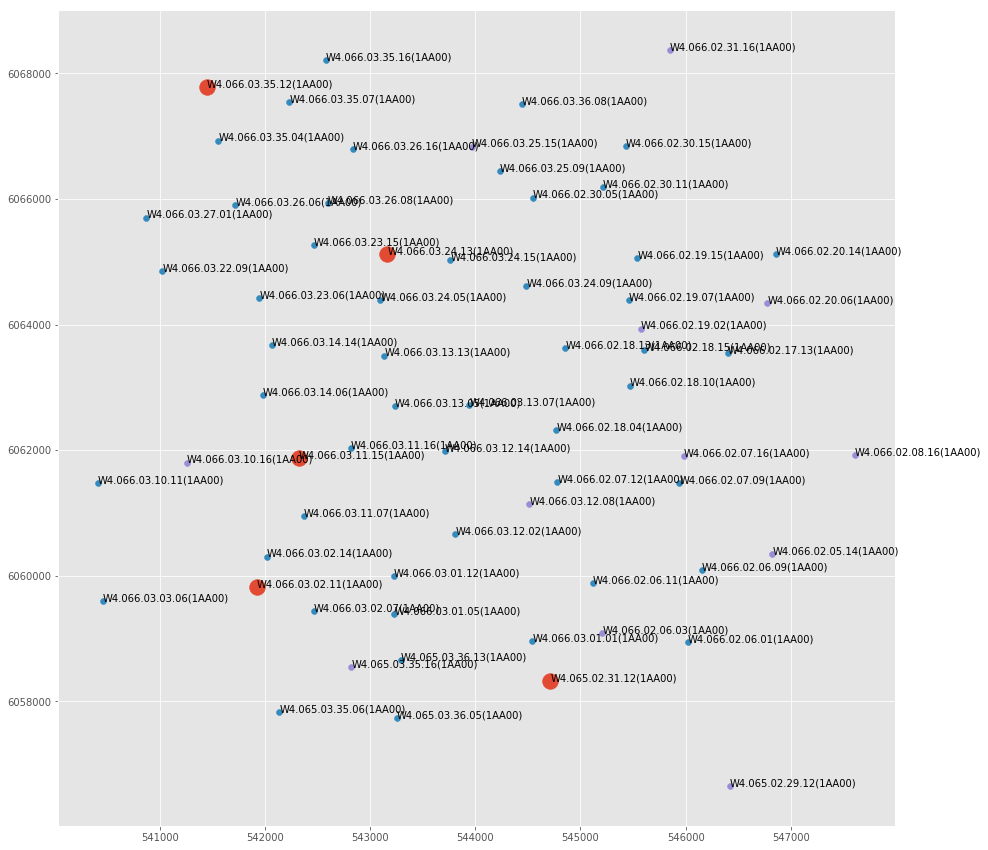

In [45]:
plt.figure(figsize=(15,15))
plt.scatter(xc5, yc5, s=250)
for i, txt in enumerate(wells5):
    plt.annotate(txt, (xc5[i], yc5[i]))
    
plt.scatter(xc50, yc50)
for i, txt in enumerate(wells50):
    plt.annotate(txt, (xc50[i], yc50[i]))

plt.scatter(xc12, yc12)
for i, txt in enumerate(wells12):
    plt.annotate(txt, (xc12[i], yc12[i]))

plt.show()

In [62]:
aa = data50['DRES'].values
aa

array(['30.922000885', '30.381999969', '30.243000031', ...,
       '7.5910000801', '7.4210000038', '7.2740001678'], dtype=object)

In [63]:
# print(data.shape)
data50 = data50[['DEPT','CALI','GR','DRES','NPSS','RHOB','DT','PEF','SP','WELL_NAME']]
data5 = data5[['DEPT','CALI','GR','DRES','NPSS','RHOB','DT','PEF','SP','WELL_NAME']]
data12 = data12[['DEPT','CALI','GR','DRES','NPSS','RHOB','DT','PEF','SP','WELL_NAME']]

data50 = data50.dropna()
data50 = data50[~data50.isin(['nan']).any(axis=1)]

data12 = data12.dropna()
data12 = data12[~data12.isin(['nan']).any(axis=1)]


# data5 = data5.dropna()
# data5 = data5[~data5.isin(['nan']).any(axis=1)]

data50.to_csv('data_50.csv', index=False)
data12.to_csv('data_12.csv', index=False)
data5.to_csv('data_5.csv', index=False)


In [76]:
data50 = pd.read_csv('data_50.csv')
data5 = pd.read_csv('data_5.csv')
data12 = pd.read_csv('data_12.csv')

data50 = data_cut(data50, survey50, wells50)
data5 = data_cut(data5, survey5, wells5)
data12 = data_cut(data12, survey12, wells12)

data50['DRES'] = np.log10(data50['DRES'].values)
data12['DRES'] = np.log10(data12['DRES'].values)
data5['DRES'] = np.log10(data5['DRES'].values)

frames = [data50, data12]
data = pd.concat(frames)

frames = [survey50, survey12]
survey = pd.concat(frames)



In [70]:
data.tail(20)

,DEPT,CALI,GR,DRES,NPSS,RHOB,DT,PEF,SP,WELL_NAME
37732,533.4508,154.385101,82.996300,0.704991,0.3369,2291.868897,372.976807,2.5794,0.125000,W4.066.03.25.15(1AA00)
37733,533.6032,152.724594,81.378799,0.771617,0.3384,2288.866211,367.517914,2.7653,-5.958300,W4.066.03.25.15(1AA00)
37734,533.7556,151.402298,86.317596,0.835646,0.3409,2282.713867,366.196411,2.9308,-6.687500,W4.066.03.25.15(1AA00)
37735,533.9080,151.929398,86.628899,0.836343,0.3471,2281.227295,365.604004,2.8160,-7.416700,W4.066.03.25.15(1AA00)
37736,534.0604,152.805496,87.413902,0.797129,0.3758,2302.763184,367.800293,2.7748,-9.020800,W4.066.03.25.15(1AA00)
37737,534.2128,152.987701,85.454201,0.791403,0.4023,2303.807373,369.768890,2.8816,-9.229200,W4.066.03.25.15(1AA00)
37738,534.3652,153.482101,80.903000,0.782365,0.4023,2261.288086,355.469788,2.9899,-11.729200,W4.066.03.25.15(1AA00)
37739,534.5176,154.191101,67.461800,0.851527,0.3715,2328.408447,318.751801,2.8334,-17.645800,W4.066.03.25.15(1AA00)
37740,534.6700,154.603394,59.505001,1.074330,0.2271,2608.279297,288.759491,3.8024,-11.375000,W4.066.03.25.15(1AA00)
37741,534.8224,153.958496,59.334801,1.260620,0.2284,2760.186768,281.933411,4.2608,-4.750000,W4.066.03.25.15(1AA00)


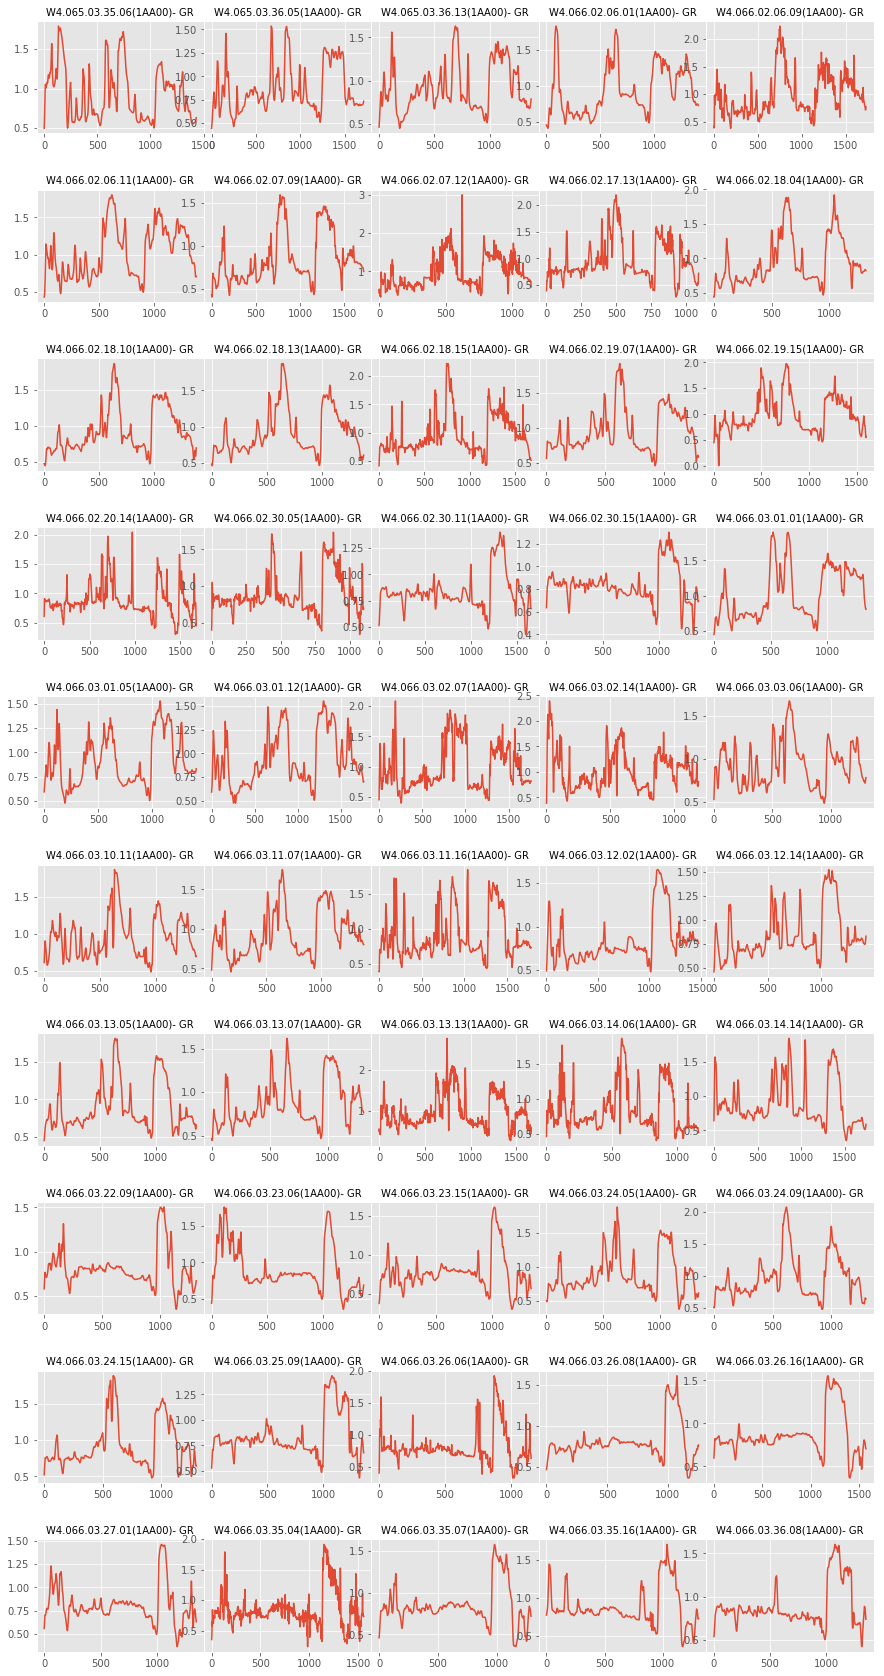

In [65]:
fig, axs = plt.subplots(10,5, figsize=(15, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(50):
    axs[i].plot(data50[data50['WELL_NAME']==data50['WELL_NAME'].unique()[i]].DRES.values)
    axs[i].set_title(data50['WELL_NAME'].unique()[i]+ '- GR', fontsize=10)

Save data to a file if necessary. We read back in:

Here we are using survey file to cut data to intervals of interest and then check for depth increment difference. If the inceremetn values are different, we interpolate and make them equal to 0.1m

You can QC data before and after inpetrpolation by plotting the data  to make sure interpolation was done correctly. 

Before:

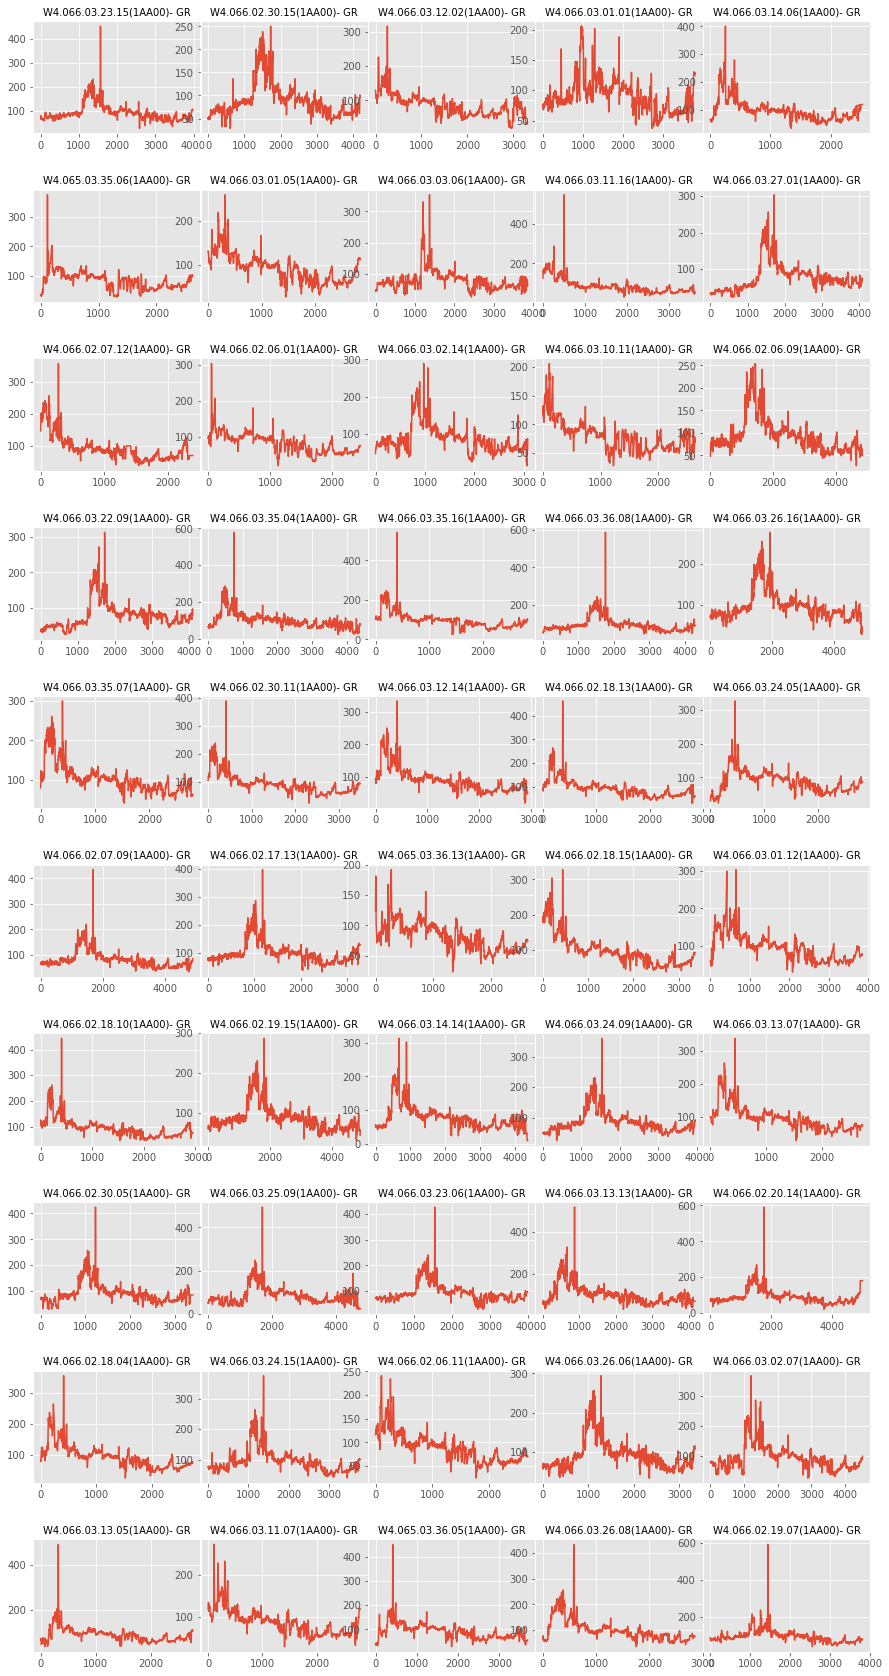

In [7]:
fig, axs = plt.subplots(10,5, figsize=(15, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(50):
    axs[i].plot(datasub[datasub['WELL_NAME']==datasub['WELL_NAME'].unique()[i]].GR.values)
    axs[i].set_title(datasub['WELL_NAME'].unique()[i]+ '- GR', fontsize=10)


After:

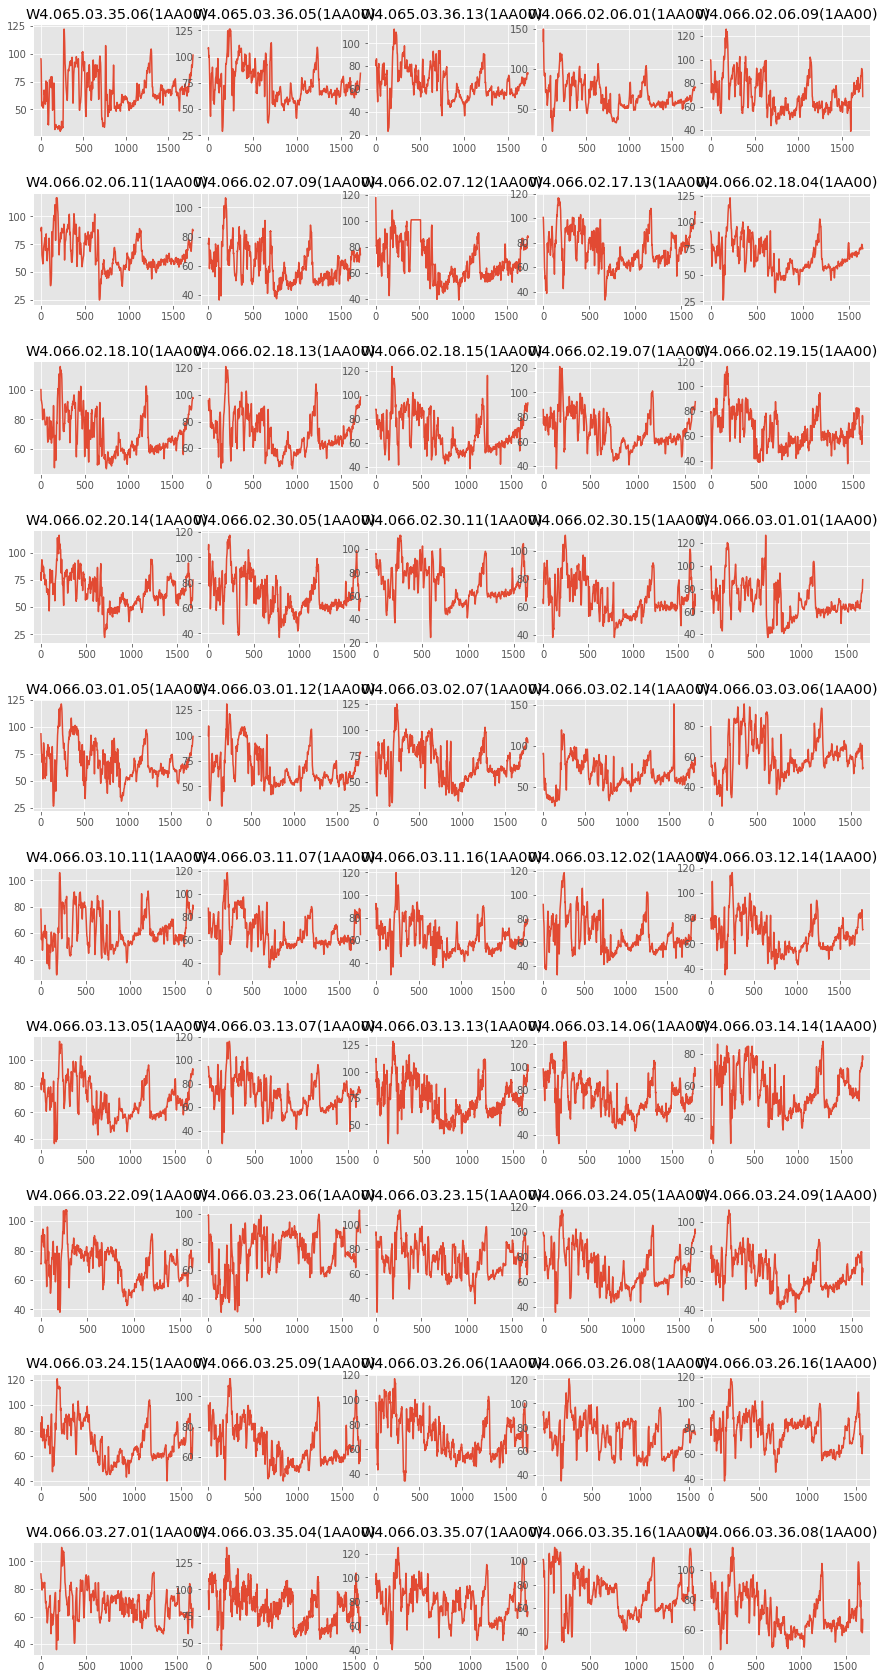

In [8]:
fig, axs = plt.subplots(10,5, figsize=(15, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(50):
    axs[i].plot(data_reg[data_reg['WELL_NAME']==data_reg['WELL_NAME'].unique()[i]].GR.values)
    axs[i].set_title(data_reg['WELL_NAME'].unique()[i]+ '- GR', fontsize=10)

After QCing the data, we can save it to a csv file:

Displaying the first few lines of data:

The first few lines of survey data:

A map showing the location of all wells:

## Choosing the Reference Well

We can start by choosing a reference well which can be a well with well defined boundaries, or a well that we already have done interpretation using core data etc. If no additional data is available, reference well can be chosen randomly. Once we choose the reference well, we can use the boundary picking function (picker) to automatically pick the boundaries of the reference well. Here we can also choose an optimal for the resolution parameter for boundary picking (shown as "res" below).
If we are happy with the boundaries on the first well, we can move on to the multi-well correlation step.

In [77]:
wells = survey['Well ID'].unique()
w1 = wells5[0]
close_wells = find_closest_wells(survey, survey5, w1, wells)
     


/Users/mehdf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mehdf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mehdf/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5984: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/mehdf/anaconda3/lib/python3

In [145]:
nwell = 15
n_test_well = 1
train = data[data['WELL_NAME'].isin(close_wells[n_test_well:nwell])] 
test = data[data['WELL_NAME'].isin(close_wells[0:n_test_well])] 

In [146]:
# data5['WELL_NAME'].unique()
# for i in range(len(data5['WELL_NAME'].unique())):
#     print(data5['WELL_NAME'].unique()[i])
#     display(data5[data5['WELL_NAME']==data5['WELL_NAME'].unique()[i]].head())
    
targets = ['DT','RHOB','DT','RHOB','GR']
remove = ['DEPT','CALI', 'WELL_NAME']

X_tr = train.drop(remove + [targets[0]], axis=1).values
X_ts = test.drop(remove + [targets[0]], axis=1).values

y_tr = train[targets[0]].values
y_ts = test[targets[0]].values

# Feature normalization
scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0)).fit(X_tr)
X_tr = scaler.transform(X_tr)
X_ts = scaler.transform(X_ts)

In [ ]:
cb_model = CatBoostRegressor(iterations=700,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='RMSE',
                             random_seed = 23,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100)
cb_model.fit(X_tr, y_tr,
             eval_set=(X_valid,y_valid),
             cat_features=categorical_features_pos,
             use_best_model=True,
             verbose=True)

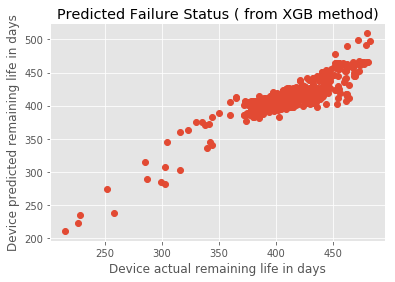

mean_squared_error 11.882283797766437
xgb============ [[1.         0.86566557]
 [0.86566557 1.        ]]


In [147]:
from xgboost.sklearn import  XGBRegressor 
import xgboost as xgb
from sklearn.metrics import confusion_matrix, mean_squared_error
from tpot import TPOTRegressor

clf = xgb.XGBRegressor(learning_rate=0.15, max_depth=2, min_child_weight=4, n_estimators=100).fit(X_tr,y_tr)
predictions = clf.predict(X_ts)

actuals = y_ts
failbuild=predictions
thres=6
failbuildxgb=(failbuild<thres)*1 + (failbuild>=thres)*failbuild
failbuildxgb=(failbuildxgb<thres)*1 + (failbuildxgb>=thres)*0.0    
from math import sqrt

scatter_plot(y_ts,predictions,'XGB')
#single_plot(failure_ts,failbuildxgb,'XGB')
print('mean_squared_error',sqrt(mean_squared_error(y_ts, predictions)))
print('xgb============',np.corrcoef(y_ts.T,predictions.T))       


In [148]:
clf = TPOTRegressor(generations=3, population_size=25, verbosity=2)
clf.fit(X_tr, y_tr)
print(clf.score(X_ts, y_ts))
clf.export('tpot_exported_pipeline.py')
yhat=clf.predict(X_ts)
   
failbuild=yhat
failbuildxgb=(failbuild<thres)*1 + (failbuild>=thres)*failbuild
failbuildxgb=(failbuildxgb<thres)*1 + (failbuildxgb>=thres)*0.0    

scatter_plot(y_ts,yhat,'TPOT')
#single_plot(failure_ts,failbuildxgb,'TPOT')
print('mean_squared_error',sqrt(mean_squared_error(y_ts, yhat)))
print(np.corrcoef(y_ts.T,yhat.T))



TPOT closed prematurely. Will use the current best pipeline.


RuntimeError: A pipeline has not yet been optimized. Please call fit() first.

Here we pick the boundaries for the first well and display them over the GR curve for the reference well:

## Doing Final Multi-Well Correlation

After determining the reference well and optimal resolution parameter for the reference well boundary picking, we are ready to to run the function for multi-well correlation:

Displaying our results:

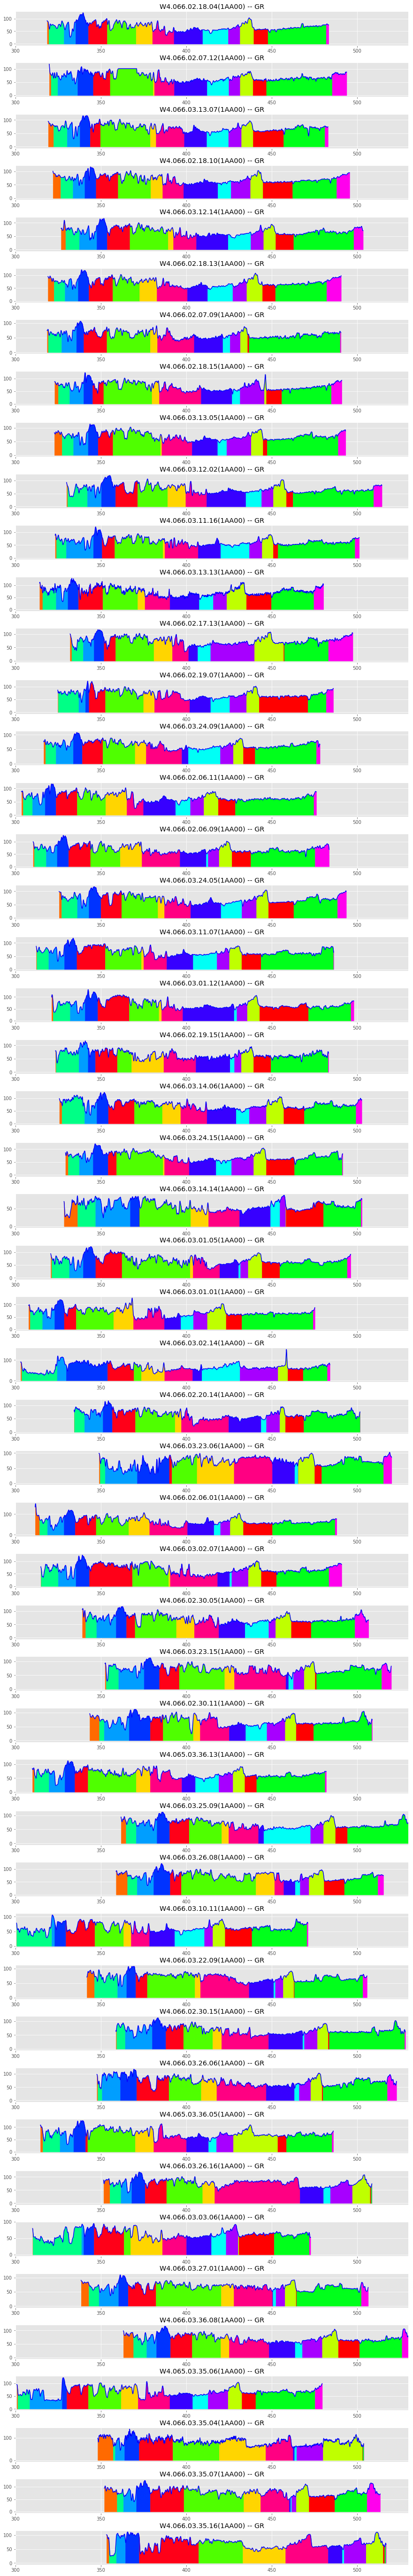

In [18]:
curve_name = 'GR'
seed = 0
np.random.seed(seed)
fig, axs = plt.subplots(50,1, figsize=(15, 100), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
# colors = cm.hsv(np.linspace(0,1,len(x_b1)+1))
colors = cm.hsv(np.linspace(0,1,len(x_b1)+1))
np.random.shuffle(colors)

for idx,w in enumerate(wells_sorted):
    x_b2 = data_reg[data_reg['Well ID'] == w]
    dp = x_b2.Depth.values
    firstwell = datasub[datasub['WELL_NAME'] == w]
    x = firstwell[curve_name].values
    dept = firstwell['DEPT'].values
    axs[idx].plot(dept,x,'b-' ,label='x')
    for idx2, s in enumerate(dp):
        if idx2 ==0:
            axs[idx].fill_between(dept,x,where = (dept<=dp[idx2]),color=colors[idx2])
        if (idx2 >0 and idx2<len(dp)-1):
            axs[idx].fill_between(dept,x,where = (dept<=dp[idx2]) & (dept>=dp[idx2-1]),color=colors[idx2])
        if idx2==len(dp)-1:
            axs[idx].fill_between(dept,x,where = (dept<=dp[idx2]) & (dept>=dp[idx2-1]),color=colors[idx2])
            axs[idx].fill_between(dept,x,where =(dept>=dp[idx2]),color=colors[idx2+1])
    axs[idx].set_xlim([300, 530])
    axs[idx].set_title(w+' -- '+curve_name)
fig.savefig('well_corr'+str(seed)+'.tif')

## Generating and saving the results / report

Running "correlate_all_wells" function generates a data frame which contains the information for all tops at each well. Formation tops are named from 0 to n in "Fm. Top" column, where n is the maximum number of layers picked. Depth of each formation at each well location is saved under "Depth column". X and Y coordinates as well as number of layers (should be the same for all well at each run) are also provided.

In [19]:
data_reg.head()

,Well ID,Fm. Top,Depth,X,Y,No. Layers
0,W4.066.02.18.04(1AA00),0,319.405,544770.83,6062318.69,14
1,W4.066.02.18.04(1AA00),1,328.305,544770.83,6062318.69,14
2,W4.066.02.18.04(1AA00),2,335.105,544770.83,6062318.69,14
3,W4.066.02.18.04(1AA00),3,342.605,544770.83,6062318.69,14
4,W4.066.02.18.04(1AA00),4,353.605,544770.83,6062318.69,14


In [20]:
data_reg.to_csv('DTW_Results.csv', index=False)